
# Reliability of XAI

In [1]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, random
warnings.filterwarnings("ignore")

if not hasattr(np, "bool"): np.bool = np.bool_
if not hasattr(np, "int"):  np.int  = int

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
import shap

def load_and_preprocess(data_path: str):
    df = pd.read_csv(data_path)

    X = df.drop(columns=["Defective"]).copy()
    y = df["Defective"].astype(int).copy()

    const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const_cols:
        print("Dropping constant columns:", const_cols)
        X.drop(columns=const_cols, inplace=True)

    if X.isna().sum().any():
        print("Missing values detected; forward/back fill.")
        X = X.fillna(method="ffill").fillna(method="bfill")
    else:
        print("No missing values detected.")
    return X, y

def make_model(random_state: int):
    return RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        random_state=random_state, n_jobs=-1, class_weight="balanced_subsample", oob_score=False
    )

def safe_smote(Xtr: pd.DataFrame, ytr: pd.Series, random_state: int):
    try:
        minority = int((ytr == 1).sum())
        k = min(5, max(1, minority - 1))
        return SMOTE(random_state=random_state, k_neighbors=k).fit_resample(Xtr, ytr)
    except Exception as e:
        print(f"[SMOTE] skipped:", e)
        return Xtr, ytr

def _shap_to_posclass_2d(sv):
    if isinstance(sv, list):
        return sv[1] if len(sv) > 1 else sv[0]
    sv = np.asarray(sv)
    if sv.ndim == 3:
        return sv[..., 1] if sv.shape[-1] >= 2 else sv.mean(axis=-1)
    return sv

def global_shap_importance(model, X_train: pd.DataFrame, X_eval: pd.DataFrame):
    bg = shap.sample(X_train, min(256, len(X_train)))
    explainer = shap.TreeExplainer(
        model, data=bg, feature_perturbation="interventional", model_output="probability"
    )
    sv = explainer.shap_values(X_eval, check_additivity=False)
    sv = _shap_to_posclass_2d(sv)
    sv_abs = np.abs(np.asarray(sv))
    return pd.Series(sv_abs.mean(axis=0), index=X_eval.columns, name="mean|SHAP|"), sv_abs

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join='inner')
    av, bv = a.values, b.values
    if np.nanstd(av) == 0 and np.nanstd(bv) == 0: return 1.0
    if np.nanstd(av) == 0 or np.nanstd(bv) == 0:  return 0.0
    return spearmanr(pd.Series(av).rank(), pd.Series(bv).rank(), nan_policy='omit').correlation

def bce_loss(p, y):
    p = np.clip(p, 1e-8, 1-1e-8)
    return -(y*np.log(p) + (1-y)*np.log(1-p))

def finite_diff_grad_loss(model, X_eval: np.ndarray, y_eval: np.ndarray, eps_vec: np.ndarray):
    n, d = X_eval.shape
    grads = np.zeros((n, d), dtype=float)
    for j in range(d):
        e = np.zeros_like(X_eval); e[:, j] = eps_vec[j]
        pp = model.predict_proba(X_eval + e)[:, 1]
        pm = model.predict_proba(X_eval - e)[:, 1]
        grads[:, j] = (bce_loss(pp, y_eval) - bce_loss(pm, y_eval)) / (2.0 * eps_vec[j] + 1e-12)
    return np.abs(grads)

def normalize_rows(A: np.ndarray, eps=1e-12):
    s = A.sum(axis=1, keepdims=True) + eps
    return A / s

def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask): 
            continue
        conf = y_prob[mask].mean()
        acc = y_true[mask].mean()
        ece += (np.sum(mask) / len(y_true)) * np.abs(acc - conf)
    return ece

def rescale01_rho(rho):
    return (rho + 1.0) / 2.0 if not np.isnan(rho) else np.nan

def evaluate_fold(model, Xtr_fit, ytr_fit, Xte: pd.DataFrame, yte: pd.Series):
    model.fit(Xtr_fit, ytr_fit)
    proba = model.predict_proba(Xte)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    metrics = {
        "AUC": roc_auc_score(yte, proba),
        "F1":  f1_score(yte, pred),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall":    recall_score(yte, pred),
        "Brier":     brier_score_loss(yte, proba),
    }
    return proba, metrics

def glr_rhos_for_fold(shap_abs_test: np.ndarray, grad_norm: np.ndarray, feature_names):
    n = shap_abs_test.shape[0]
    rhos = []
    for i in range(n):
        s = pd.Series(shap_abs_test[i, :], index=feature_names)
        g = pd.Series(grad_norm[i, :],      index=feature_names)
        rhos.append(float(spearman_rank_corr(s, g)))
    return rhos

def epsilon_hitk_for_subset(model, Xte_np, yte_np, shap_abs_test, top_k, eps, m_limit, chosen_idx):
    hits = []
    d = Xte_np.shape[1]
    proba = model.predict_proba(Xte_np)[:, 1]
    base_loss = bce_loss(proba, yte_np)

    for i in chosen_idx:
        x = Xte_np[i, :]; y_i = yte_np[i]
        shap_vec = shap_abs_test[i, :]
        M = min(m_limit, d)
        cand_idx = np.argsort(-shap_vec)[:M]
        topk_shap_idx = cand_idx[:top_k]

        X_batch = np.tile(x, (M, 1))
        X_batch[np.arange(M), cand_idx] += eps
        p_pert = model.predict_proba(X_batch)[:, 1]
        dL = bce_loss(p_pert, np.full(M, y_i)) - base_loss[i]
        topk_delta_idx = cand_idx[np.argsort(-dL)[:top_k]]

        hits.append(int(len(set(topk_shap_idx).intersection(set(topk_delta_idx))) > 0))
    return hits

def plot_top_features(global_mean_shap_accum, topn=10):
    if not global_mean_shap_accum:
        return
    shap_df = pd.concat(global_mean_shap_accum, axis=1)
    shap_mean = shap_df.mean(axis=1).sort_values(ascending=False)
    N = min(topn, len(shap_mean))
    topN = shap_mean.head(N)[::-1]
    plt.figure(figsize=(8, max(4, N*0.5)))
    plt.barh(topN.index, topN.values)
    plt.xlabel("mean(|SHAP|) across folds (test)")
    plt.ylabel("Feature")
    plt.title(f"Top {N} Features by SHAP (Test, mean across folds)")
    plt.tight_layout()
    plt.show()

def run_pipeline(
    data_path="./../dataset/CM1.csv",
    n_splits=5,
    rng=42,
    top_k=10,
    eps=1e-3,
    calib_bins=10,
    m_limit=20,
    max_eps_samples=50,
    plot=True,
):
    np.random.seed(rng); random.seed(rng)

    X, y = load_and_preprocess(data_path)
    feature_names = X.columns.tolist()
    d = len(feature_names)
    eps_vec = np.full(d, eps, dtype=float)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    per_fold_metrics = []
    all_proba, all_y = [], []
    all_glr_rhos = []
    hitk_flags = []
    global_mean_shap_accum = []
    eps_samples_used = 0

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr, yte = y.iloc[tr].copy(), y.iloc[te].copy()

        Xtr_fit, ytr_fit = safe_smote(Xtr, ytr, random_state=fold)

        rf = make_model(random_state=fold)

        proba, metrics = evaluate_fold(rf, Xtr_fit, ytr_fit, Xte, yte)
        per_fold_metrics.append({"fold": fold, **metrics})
        all_proba.append(proba); all_y.append(yte.values)

        g_test_series, shap_abs_test = global_shap_importance(rf, Xtr_fit, Xte)
        global_mean_shap_accum.append(g_test_series)

        Xte_np = Xte.values.astype(float)
        yte_np = yte.values.astype(int)
        grad_abs  = finite_diff_grad_loss(rf, Xte_np, yte_np, eps_vec)
        grad_norm = normalize_rows(grad_abs)

        all_glr_rhos.extend(glr_rhos_for_fold(shap_abs_test, grad_norm, feature_names))

        if eps_samples_used < max_eps_samples:
            idxs = np.arange(len(Xte_np))
            np.random.shuffle(idxs)
            take = min(max_eps_samples - eps_samples_used, max(1, len(idxs)//6))  # ~15–20% per fold
            chosen = idxs[:take]
            hitk_flags.extend(
                epsilon_hitk_for_subset(rf, Xte_np, yte_np, shap_abs_test, top_k, eps, m_limit, chosen)
            )
            eps_samples_used += take

    per_fold_df = pd.DataFrame(per_fold_metrics)
    AUC_mean   = float(per_fold_df["AUC"].mean())
    F1_mean    = float(per_fold_df["F1"].mean())
    P_mean     = float(per_fold_df["Precision"].mean())
    R_mean     = float(per_fold_df["Recall"].mean())
    Brier_mean = float(per_fold_df["Brier"].mean())

    GLR_mean = float(np.nanmean(all_glr_rhos)) if len(all_glr_rhos) else np.nan
    Hitk     = float(np.mean(hitk_flags))      if len(hitk_flags)  else np.nan

    all_proba = np.concatenate(all_proba, axis=0)
    all_y     = np.concatenate(all_y, axis=0)
    ECE       = float(expected_calibration_error(all_y, all_proba, n_bins=calib_bins))

    ReliabilityScore = np.nanmean([rescale01_rho(GLR_mean), Hitk, max(0.0, 1.0 - ECE)])

    summary = pd.DataFrame([{
        "AUC_mean": AUC_mean, "F1_mean": F1_mean, "Precision_mean": P_mean, "Recall_mean": R_mean,
        "Brier_mean": Brier_mean, 
        "GLR_mean": GLR_mean, f"Hit@{top_k}": Hitk,
        "ECE": ECE, "ReliabilityScore": ReliabilityScore, "eps_samples_used": eps_samples_used
    }]).round(4)

    if plot:
        plot_top_features(global_mean_shap_accum, topn=10)

    artifacts = {
        "per_fold_metrics": per_fold_df,
        "glr_rhos": np.array(all_glr_rhos, dtype=float),
        "all_proba": all_proba,
        "all_y": all_y,
        "top_shap_mean_test": (pd.concat(global_mean_shap_accum, axis=1).mean(axis=1)
                               if len(global_mean_shap_accum) else pd.Series(dtype=float))
    }
    return summary, artifacts

No missing values detected.


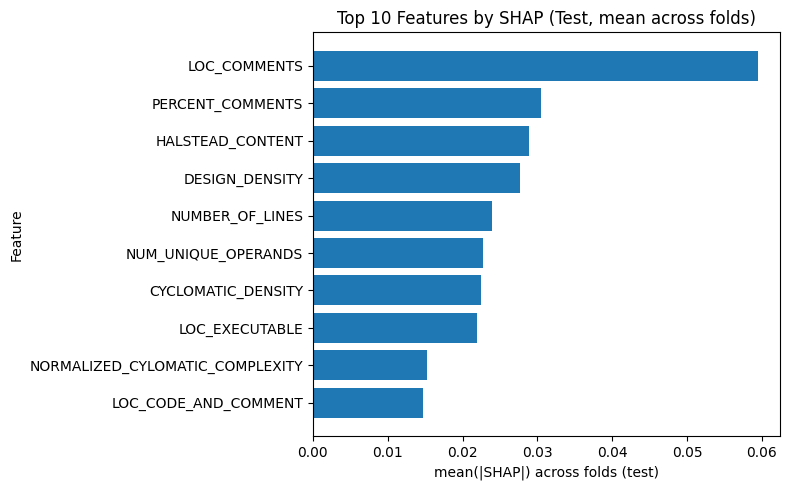

,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,0.7315,0.2349,0.2982,0.2444,0.1322,0.0847,1.0,0.1098,0.8108,50


In [2]:
summary, artifacts = run_pipeline(
    data_path="./../../dataset/CM1.csv",
    n_splits=5,
    rng=42,
    top_k=10,
    eps=1e-3,
    calib_bins=10,
    m_limit=20,
    max_eps_samples=50,
    plot=True
)
summary